**22_whirl**

In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from pathlib import Path  
from flopy.plot.styles import styles ; import shapefile as shp ; import matplotlib as mpl ; import pandas as pd  
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True); from matplotlib import gridspec

In [2]:
sim_ws  = Path("./22_whirl")                         ; sim_ws.mkdir(exist_ok=True)       ; sim_name = "ex-gwf-whirl"
ex1     = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'    ; workspace = figs_path = sim_ws    ; ws = output_folder = sim_ws   

In [3]:
length_units = "meters"   ; time_units = "days"   ; nper = 1 ;nouter = 50 ; ninner = 100 ;hclose = 0.000000001 ; rclose = 0.000001 
nlay = 10      ;nrow = 12 ; ncol = 51             ;delr = 100 ;delc = 100 ;top = 0 ; strt = 0  ;icelltype = 0  ; k11 =1 ; k22 =0.1 ;k33 =1 
inflow_rate = 0.01 ;perlen = [1.0] ;nstp = [1] ;tsmult = [1.0] 

botm_str = "-100, -200, -300, -400, -500, -600, -700, -800, -900, -1000"  ; angle1_str = "45, 45, 45, 45, 45, -45, -45, -45, -45, -45"  
#angle1_str = "90, 90, 90, 90, 90, -90, -90, -90, -90, -90"  
#angle1_str = "0, 0, 0, 0, 0, -0, -0, -0, -0, -0"  
#angle1_str = "75, 75, 75, 75, 75, -75, -75, -75, -75, -75"  
tdis_ds=list(zip(perlen,nstp,tsmult)) ;botm=[float(value)for value in botm_str.split(",")]  ;angle1=[float(value)for value in angle1_str.split(",")]

In [4]:
def build_models():
    rate       = np.zeros((nlay, nrow, ncol), dtype=float)                          ; rate[:,:,0]=inflow_rate   ; rate[:,:,-1]=-inflow_rate
    wZ, wR, wL = np.where(rate != 0.0)     ;wel_spd=[((k, i, j), rate[k, i, j]) for k,i,j in zip(wZ, wR, wL)]   ; wel_spd={0:wel_spd}
    head_filerecord=f"{sim_name}.hds" ; budget_filerecord=f"{sim_name}.cbc"

    sim = flopy.mf6.MFSimulation (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms  (sim,linear_acceleration="bicgstab",outer_maximum=nouter,outer_dvclose=hclose,
                               inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose}strict")
    gwf=flopy.mf6.ModflowGwf (sim,modelname=sim_name,save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf  (gwf,icelltype=icelltype,  k=k11,  k22=k22,  k33=k33  ,angle1=angle1, save_specific_discharge=True,xt3doptions=True)
    flopy.mf6.ModflowGwfic   (gwf, strt=strt)
    flopy.mf6.ModflowGwfwel  (gwf,stress_period_data=wel_spd,pname="WEL")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])
    return sim
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=False):     success, buff = sim.run_simulation(silent=silent, report=True)  ; assert success, buff
def scenario(idx, silent=True):
    sim = build_models()
    if write:  write_models(sim, silent=silent) 
    if run:  run_models(sim, silent=silent)
scenario(0)

run_models took 298.91 ms


In [5]:
sim = build_models() ; gwf = sim.get_model(sim_name); hobj = gwf.output.head()  ;  head = hobj.get_data(totim=1.0) ; print(head.shape)
cobj = gwf.output.budget()  ; spd = cobj.get_data(text="DATA-SPDIS")[0]   ; qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd, gwf)

(10, 12, 51)


In [6]:
botmB = pd.DataFrame(botm) ; angle1B = pd.DataFrame(angle1) ; df = pd.concat([botmB[:], angle1B[:]], axis=1); 
df.columns=['Z_layers', 'HANI_angle1_XY']; df.tail() ; ss =np.max(head) - np.min(head); levels=np.arange(np.min(head[0]), np.max(head[0]), ss/10) 

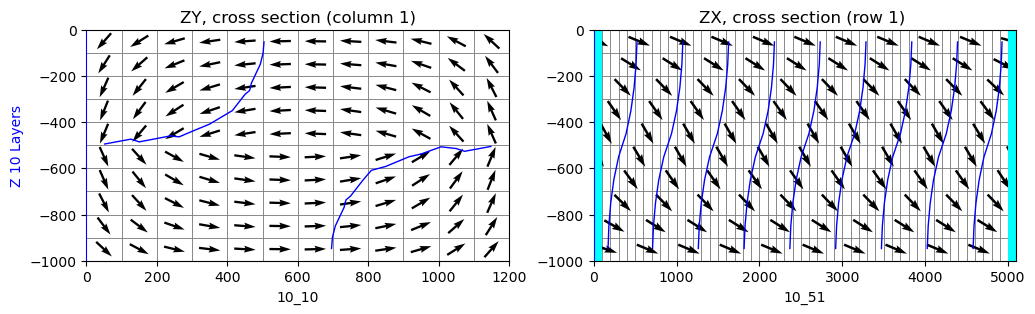

In [7]:
fig = plt.figure(figsize=(12, 3))   ; fig.tight_layout()      
ax = fig.add_subplot(121)    ; ax.set_title("ZY, cross section (column 1)")  
pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": 3}) ; pxs.plot_grid(linewidth=0.5)     ; pxs.plot_vector(qx,qy,qz,normalize=True) 
ax.set_xlabel("10_10") ; ax.set_ylabel("Z 10 Layers")   ; ax.yaxis.label.set_color('blue') ; ax.spines['left'].set_color('blue')     
pxs.contour_array(head,levels=levels,linewidths=1,colors="b",linestyles="solid")
pxs.plot_bc("Wel", color="cyan")

ax = fig.add_subplot(122)    ; ax.set_title("ZX, cross section (row 1) ")  
pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})  ; pxs.plot_grid(linewidth=0.5) ; pxs.plot_vector(qx,qy,qz,normalize=True,hstep=5) 
ax.set_xlabel("10_51")  ;ax.yaxis.label.set_color('blue') ;ax.spines['left'].set_color('blue'); 
pxs.plot_bc("Wel", color="cyan")    
pxs.contour_array(head,levels=levels,linewidths=1,colors="b",linestyles="solid"); plt.show() 

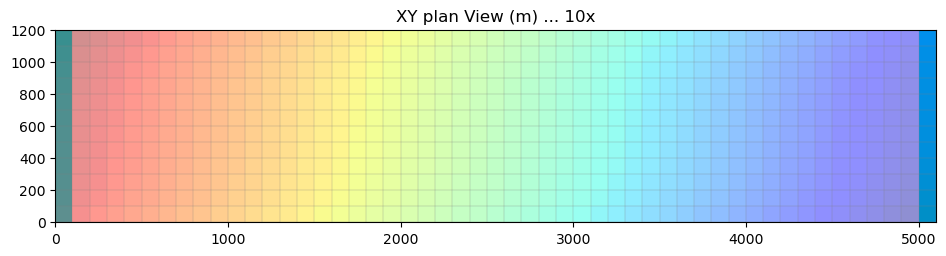

In [8]:
fig = plt.figure(figsize=(25, 2.5))    ; fig.tight_layout()     
ax = fig.add_subplot(121)  ; head = gwf.output.head().get_data()   ; h_L0 = pd.DataFrame(head[0,:,:])
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)  ; pmv.plot_bc("WEL", plotAll=True,color="cyan") ; ax.set_title("XY plan View (m) ... 10x") 
cb = pmv.plot_array(head, cmap="jet", alpha=0.25)        ; pmv.plot_grid(linewidth=0.2)    ; plt.show() 

In [9]:
rate = np.zeros((nlay,nrow,ncol),dtype = float) ;rate[:,:,0] = inflow_rate ;rate[:,:,-1] = -inflow_rate ; wellay,welrow,welcol = np.where(rate!=0.0) 
wel_spd = [((k,i,j),rate[k,i,j]) for k,i,j in zip(wellay,welrow,welcol)] ;sa = pd.DataFrame(wel_spd) ;sa.to_csv(output_folder/"01_wel_spd.csv") ;
print('nº wells at each cell .. last face', sa.shape) ; sa.columns=['Kij', 'Q'];  #sa.tail()
sa2 = sa['Kij']; sa3 = sa2.tolist() ; np.savetxt(output_folder / "03_.csv", sa3, delimiter=",") 
sa4=pd.DataFrame(sa3); sa5 = sa4.rename(columns = lambda x : 'b' + str(x)); df = pd.concat([sa[:], sa5[:]], axis=1)
df.to_csv (output_folder / "04b_Wel.csv") ; df.head() 

nº wells at each cell .. last face (240, 2)


,Kij,Q,b0,b1,b2
0,"(0, 0, 0)",0.01,0,0,0
1,"(0, 0, 50)",-0.01,0,0,50
2,"(0, 1, 0)",0.01,0,1,0
3,"(0, 1, 50)",-0.01,0,1,50
4,"(0, 2, 0)",0.01,0,2,0


In [10]:
vvv   = [(0,0,2),(0,1,2),(0,2,2),(0,3,2),(0,17,2),(0,18,2),(0,19,2),(0,20,2)] ; 
part1 = flopy.modpath.ParticleData(vvv, drape=1, structured=True, particleids=[1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008])  
pg1 =flopy.modpath.ParticleGroup(particledata=part1,filename="Track_new") ; particlegroups=[pg1] ;np.savetxt(sim_ws/"02_path_IN.csv",vvv,delimiter=",")

In [ ]:
exe_name = "mp7"                #  ; zone3 = np.ones((nrow, ncol), dtype=np.int32)   ;  zone3[wel_loc[1:]] = 2  ; zones = [0, 0, zone3]
mp    = flopy.modpath.Modpath7    (modelname=sim_name + "_mp", flowmodel=gwf, exe_name=exe_name, model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas (mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim (mp, simulationtype="combined"  ,trackingdirection ="forward",weaksinkoption ="pass_through",
                                   weaksourceoption="pass_through",budgetoutputoption="summary",stoptimeoption ="extend",
                                   zonedataoption="on"    ,  particlegroups = particlegroups)   # zones  # particlegroups
mp.write_input() ; mp.run_model(silent=True, report=True)